# Combined Bachelor Thesis (NS-320B), June 2022
## Mathematics & Physics and Astronomy
*'Applying Physics-informed Neural Networks to Chaotic Systems of Ordinary Differential Equations'*

**Author:** Martijn Sebastiaan Brouwer (6859488)

**Mathematics supervisors:** prof. dr. ir. C.W. Oosterlee

**Physics supervisor:** dr. J. de Graaf

**PhD supervisor:** B. Negyesi

# Application of PiNNs when only the initial condition and parameters are specified

## Making directories and importing packages

In [1]:
!mkdir plots
!mkdir plots_x
!mkdir plots_y
!mkdir plots_z

from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
time = datetime.now()

warnings.simplefilter(action='ignore', category=FutureWarning)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
torch.manual_seed(12345)
np.random.seed(12345)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Tue May 17 15:12:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Definitions 
### (Fully Connected Network (FCN), Runge-Kutta fourth order method, plotting and saving animated gifs)

In [2]:
# ----------------------------------------------------------------------------- 
# -------------------------- Fully Connected Network --------------------------
# ----------------------------------------------------------------------------- 
class FCN(nn.Module): 
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh #Specify the used activation function
        self.fc1 = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()]) #Input to first hidden layer
        self.fc2 = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS-1)]) #Going through the remaining hidden layers
        self.fc3 = nn.Linear(N_HIDDEN, N_OUTPUT) #Last hidden layer to output layer

    def forward(self, *args):
        if len(args) == 1: #When multiple initial conditions are specified, this will provide the correct shape. 
            x = args[0]
        elif len(np.shape(args[0])) <= 1:
            x = torch.FloatTensor([*args]).T
        else:
            x = torch.FloatTensor(torch.cat([*args], 1))

        x = self.fc1(x) #Going through the layers
        x = self.fc2(x)
        x = self.fc3(x)
        return x


# ----------------------------------------------------------------------------- 
# ---------------------- Runge-Kutta fourth order method ---------------------- 
# ----------------------------------------------------------------------------- 
def RungeKutta(dxdt,dydt,dzdt, x0,y0,z0, ti,tf,n): # Specify derivatives, initial conditions and time
    h = tf/n #Step size
    xl,yl,zl = n*[0],n*[0],n*[0] #Create lists for output
    xl[0],yl[0],zl[0] = x0,y0,z0 #First element in output-list is the initial condition
    for i in range(1,n): #Loop over steps while skipping the first one due to the initial condition
        x,y,z = xl[i-1],yl[i-1],zl[i-1]
        #Going through the four RK4 equations:
        k1x,k1y,k1z = (h*f(x,y,z)    for f in (dxdt,dydt,dzdt))
        xs,ys,zs    = (r + 0.5*kr    for r,kr in zip((x,y,z),(k1x,k1y,k1z,h)))
        k2x,k2y,k2z = (h*f(xs,ys,zs) for f in (dxdt,dydt,dzdt))
        xs,ys,zs    = (r + 0.5*kr    for r,kr in zip((x,y,z),(k2x,k2y,k2z,h)))
        k3x,k3y,k3z = (h*f(xs,ys,zs) for f in (dxdt,dydt,dzdt))
        xs,ys,zs    = (r + kr        for r,kr in zip((x,y,z),(k3x,k3y,k3z,h)))
        k4x,k4y,k4z = (h*f(xs,ys,zs) for f in (dxdt,dydt,dzdt))
        #Update last next value in output list:
        xl[i],yl[i],zl[i] = (r + (k1r + 2*k2r + 2*k3r + k4r)/6 for r,k1r,k2r,k3r,k4r in 
                zip((x,y,z),(k1x,k1y,k1z),(k2x,k2y,k2z),(k3x,k3y,k3z),(k4x,k4y,k4z)))
    return xl,yl,zl


# ----------------------------------------------------------------------------- 
# -------------- 3D plot of RK4 approximation and PINN prediction ------------- 
# ----------------------------------------------------------------------------- 
def plot_result(x,y,z, x_data,y_data,z_data, xh,yh,zh):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(x,y,z, color="black", linewidth=1, alpha=0.8, label="RK4 solution")
    ax.plot(xh,yh,zh, color="tab:blue", linewidth=2, alpha=0.8, label="PiNN prediction")
    ax.scatter(x_data, y_data, z_data, s=60, color="tab:orange", alpha=0.4, label='Initial condition')
    l = plt.legend(loc=(1.1,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    ax.text2D(0.11, 0.07, "Training step: %i"%(i+1), fontsize="x-large", color="k")
    ax.text2D(0.11, 0.05, "Loss1: {:.2e}".format(loss1), fontsize="x-large", color="k")
    ax.text2D(0.11, 0.03, "Loss2: {:.2e}".format(loss2), fontsize="x-large", color="k")
    ax.text2D(0.11, -0.05, "Learning rate: %.0E"%(lr), fontsize="x-large", color="k")
    ax.text2D(0.11, -0.07, "Hidden layers: ({}x{})".format(N_LAYERS, N_HIDDEN), fontsize="x-large", color="k")
    ax.text2D(0.11, -0.09, "Optimizer: Adam", fontsize="x-large", color="k")
    ax.text2D(0.11, -0.11, "$t_f$ = {:.1f}, $\\alpha$ = {:.2g}, $t_u$ = {:.1g}".format(tf, alpha, update_t), fontsize="x-large", color="k")
    ax.text2D(0.11, -0.13, "($\\sigma$,$\\rho$,$\\beta$) = ({},{},8/3) and ($x_0$,$y_0$,$z_0$) = ({},{},{})".format(sigma,rho,x0,y0,z0), fontsize="x-large", color="k")
    ax.set_xlabel('$x$', fontsize="x-large")
    ax.set_ylabel('$y$', fontsize="x-large")
    ax.set_zlabel('$z$', fontsize="x-large")

# ----------------------------------------------------------------------------- 
# -------------- 2D plot of RK4 approximation and PINN prediction ------------- 
# ----------------------------------------------------------------------------- 
def plot2D(t,exact,t_pred,pred,init,axis):
    plt.figure()
    plt.plot(t,exact, color="grey", linewidth=2, alpha=0.8, label="RK4 solution")
    plt.plot(t_pred, pred, color="tab:blue", linewidth=2, alpha=0.6, label="PiNN prediction")
    plt.scatter(t[0],init, s=60, color="tab:orange", alpha=0.4, label='Training data')
    l = plt.legend(loc=(1.05,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.annotate("Training step: %i"%(i+1),xy=(1.05, 0.87),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("Loss1: {:.2e}".format(loss1),xy=(1.05, 0.77),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("Loss2: {:.2e}".format(loss2),xy=(1.05, 0.67),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("Learning rate: %.0E"%(lr),xy=(1.05, 0.25),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("Hidden layers: ({}x{})".format(N_LAYERS, N_HIDDEN),xy=(1.05, 0.15),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("Optimizer: Adam",xy=(1.05, 0.05),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("$t_f$ = {:.1f}, $\\alpha$ = {:.2g}, $t_u$ = {:.1g}".format(tf, alpha, update_t),xy=(1.05, -0.05),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("($\\sigma$, $\\rho$, $\\beta$) = ({},{},8/3) and ($x_0$,$y_0$,$z_0$) = ({},{},{})".format(sigma,rho,x0,y0,z0),xy=(1.05, -0.15),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.ylabel('${}$'.format(axis), fontsize="x-large")
    plt.xlabel('Timestep $t$', fontsize="x-large")

# ----------------------------------------------------------------------------- 
# -------------------------- Creating GIF animations -------------------------- 
# ----------------------------------------------------------------------------- 
def save_gif(outfile, files, fps=5, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)


## Parameters of the Lorenz system and the PiNN

In [4]:
# ----------------------------------------------------------------------------- 
# -------------------------- Lorenz system parameters ------------------------- 
# ----------------------------------------------------------------------------- 
x0,y0,z0 = 8,8,8              #Initial conditions
sigma,rho,beta = 10,28,8/3    #Parameters of system
ti = 0                        #Initial time
tf = 0.3                      #Starting final time (without update yet)
n = 1000                      #Steps taken between ti and tf
h = tf/n                      #Stepsize of each step of n

# ----------------------------------------------------------------------------- 
# ------------------------------ PiNN parameters ------------------------------ 
# ----------------------------------------------------------------------------- 
lr = 1e-3                     #Learning rate
INPUT = 1                     #Amount of input values
N_HIDDEN = 32                 #Amount of hidden layers
N_LAYERS = 3                  #Amount of neurons in hidden layers
OUTPUT = 3                    #Amount of output values
alpha = 0.01                  #Threshold value for updating tf with update_t
update_t = 0.3                #Update value for tf after reaching threshold
iterations = 1000000          #Total amount of iterations
intermediate = 1000           #Safe intermediate results after every {intermediate} iterations

# ----------------------------------------------------------------------------- 
# ----------------------- Lorenz differential equations ----------------------- 
# ----------------------------------------------------------------------------- 
def dxdt_def(x,y,z): return -sigma*x + sigma*y
def dydt_def(x,y,z): return -x*z + rho*x - y
def dzdt_def(x,y,z): return x*y - beta*z

# The Physics-informed Neural Network

PiNN, iteration: 100, loss1: 118.55765533447266, loss2: 204.79660034179688, time: 0:00:40.312482


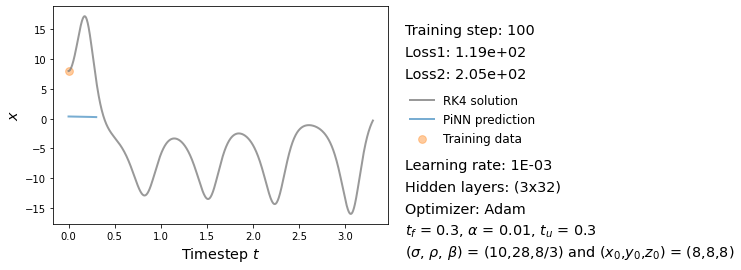

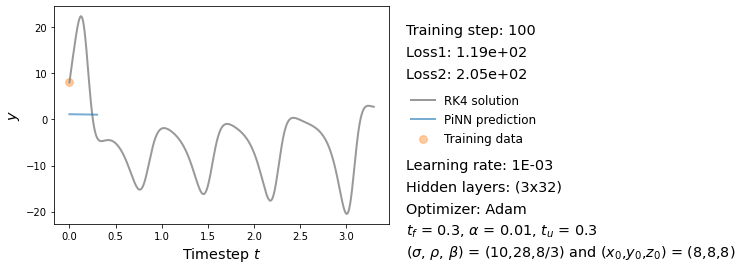

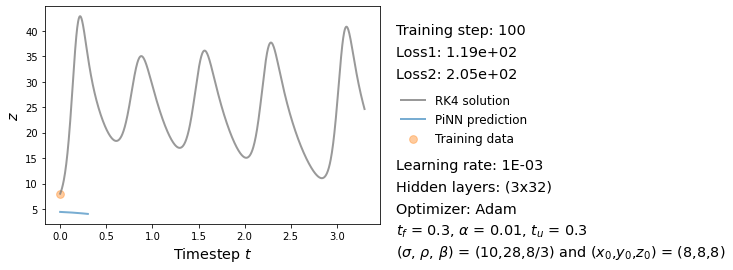

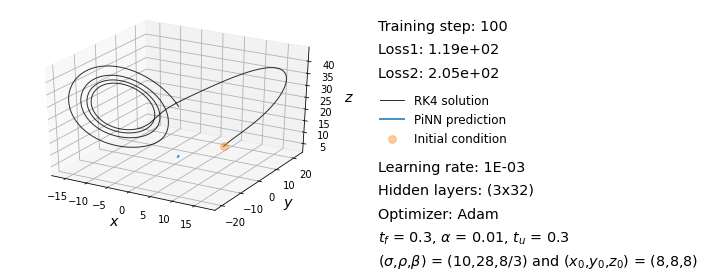

PiNN, iteration: 200, loss1: 102.0711669921875, loss2: 150.47581481933594, time: 0:00:42.916613


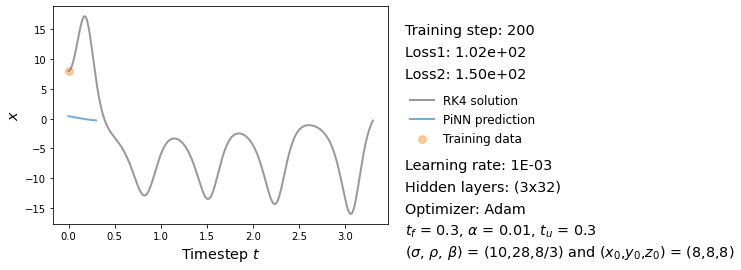

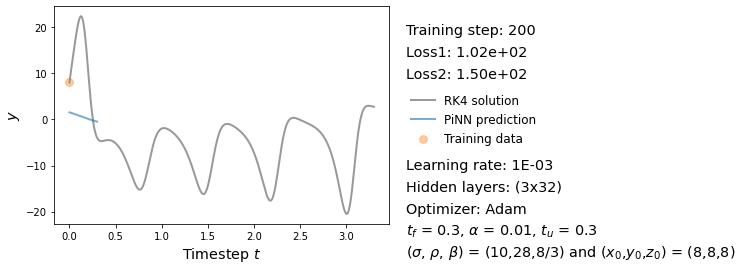

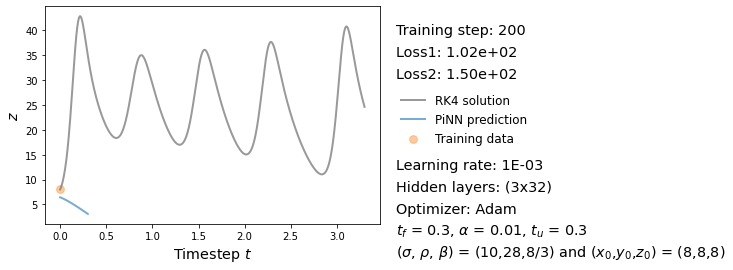

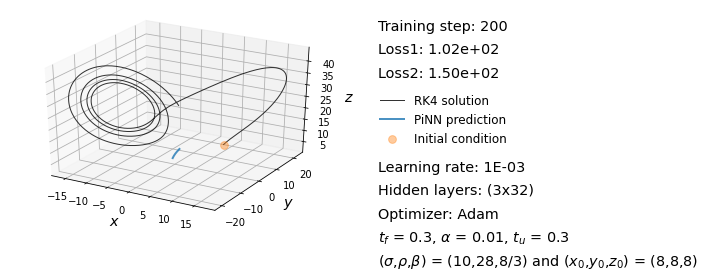

PiNN, iteration: 300, loss1: 96.59449005126953, loss2: 144.14979553222656, time: 0:00:45.362049


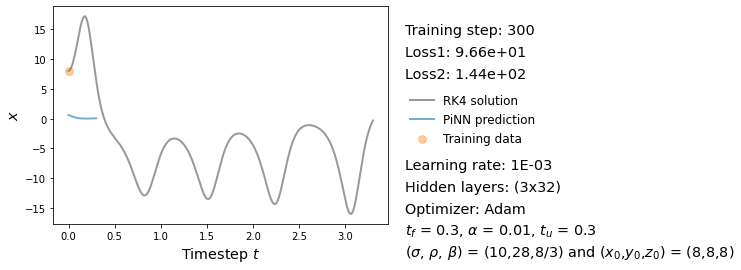

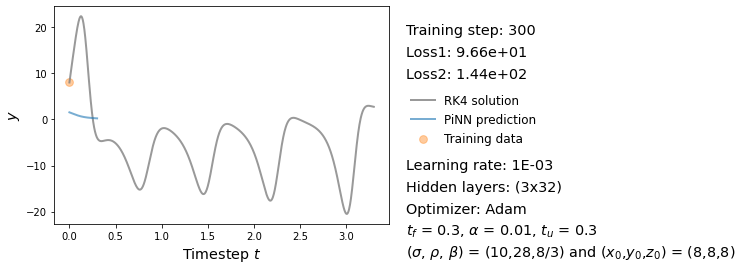

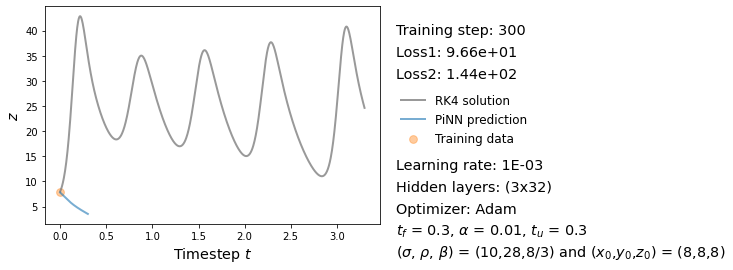

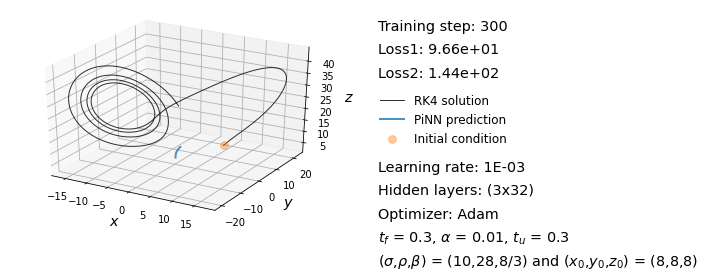

PiNN, iteration: 400, loss1: 95.59467315673828, loss2: 147.769775390625, time: 0:00:47.806841


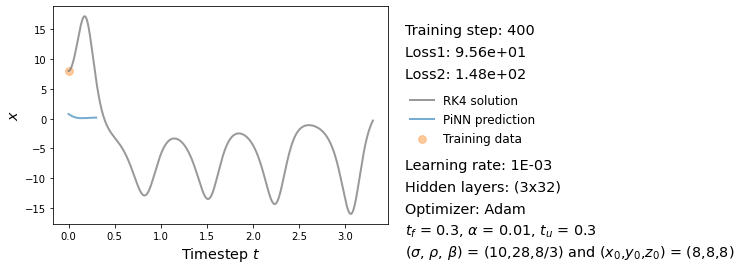

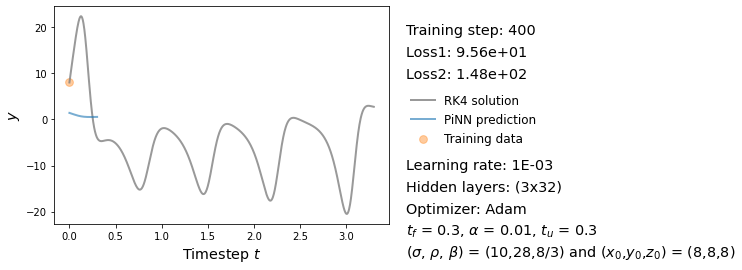

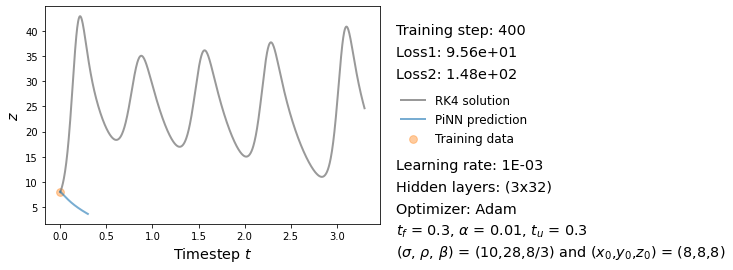

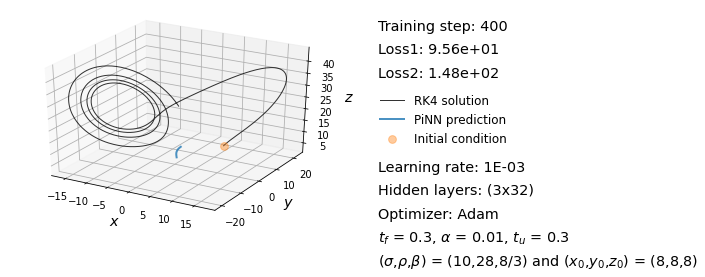

PiNN, iteration: 500, loss1: 95.14506530761719, loss2: 150.10740661621094, time: 0:00:50.196654


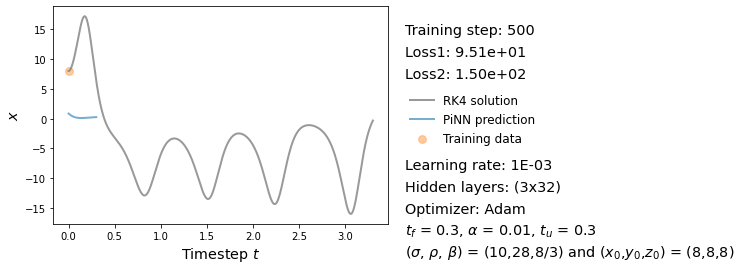

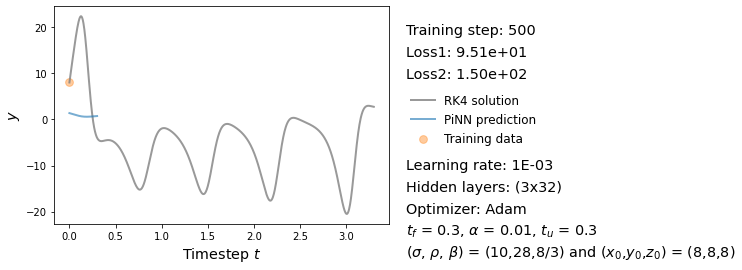

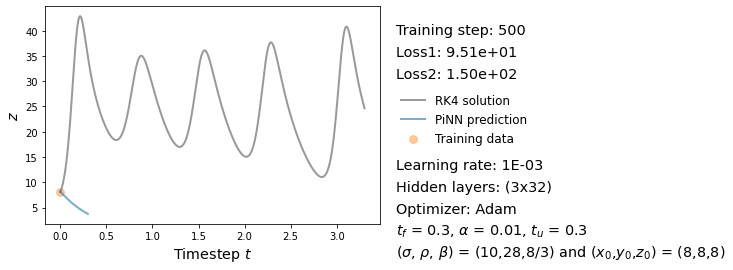

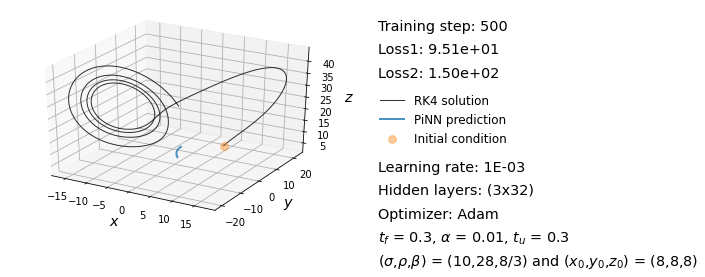

PiNN, iteration: 600, loss1: 94.86027526855469, loss2: 150.5601806640625, time: 0:00:52.566611


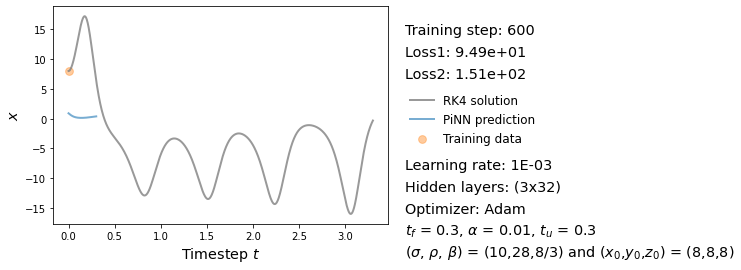

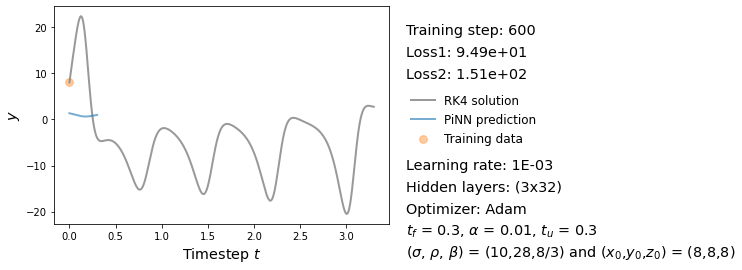

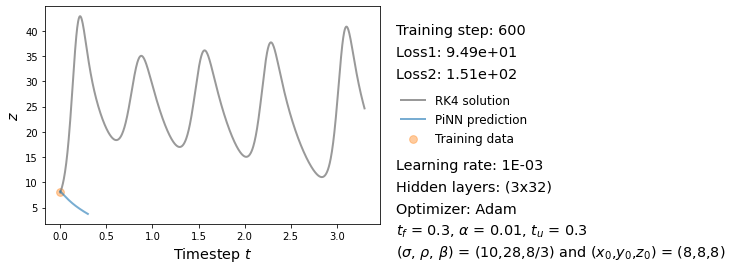

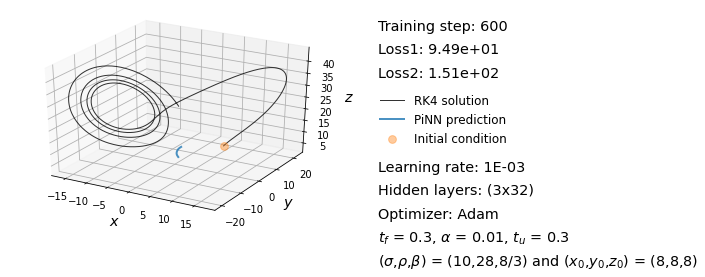

PiNN, iteration: 700, loss1: 94.48983764648438, loss2: 151.03614807128906, time: 0:00:54.994429


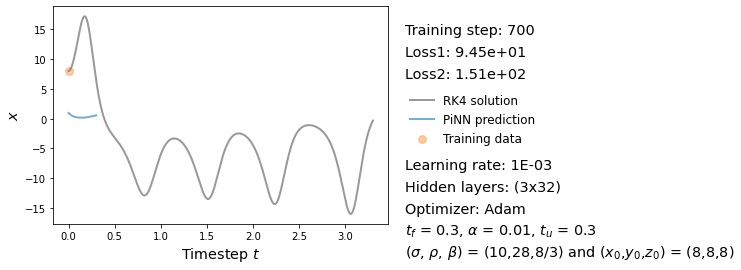

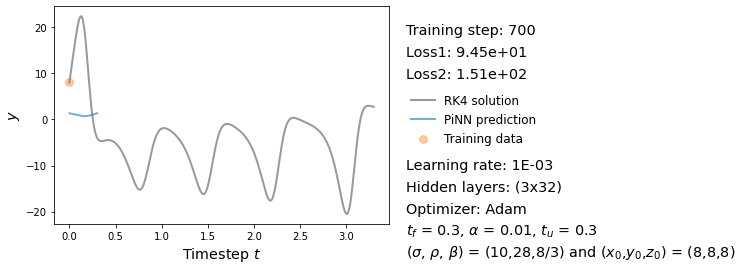

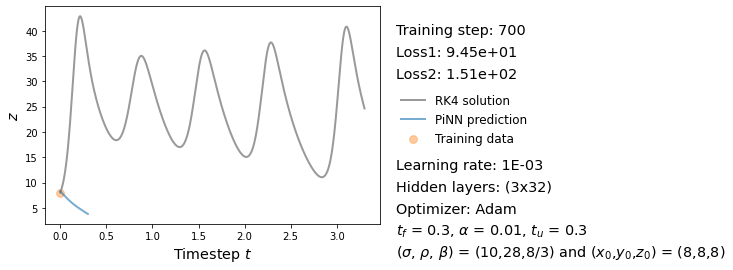

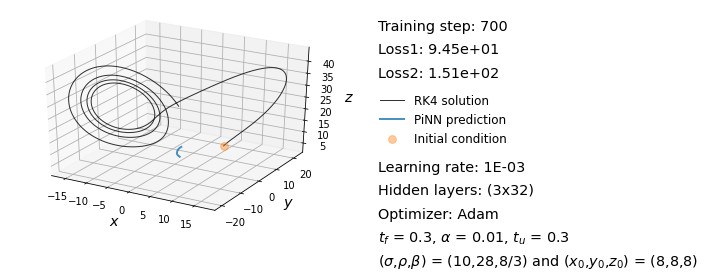

PiNN, iteration: 800, loss1: 93.90767669677734, loss2: 151.50119018554688, time: 0:00:57.472682


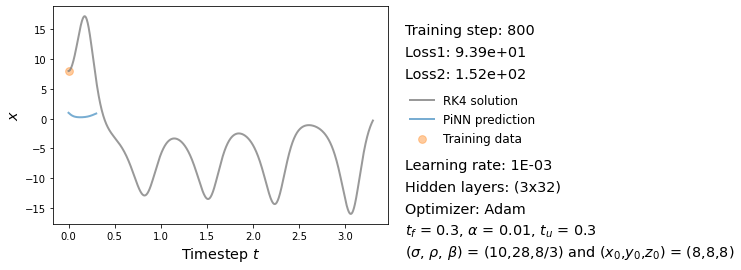

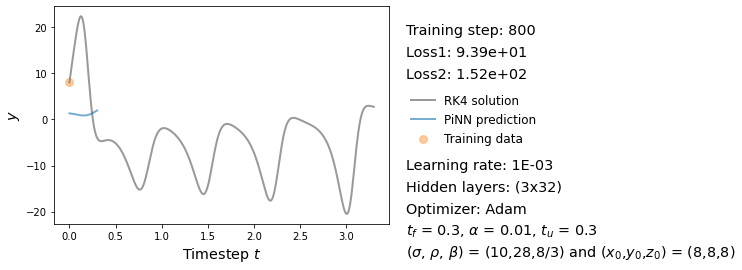

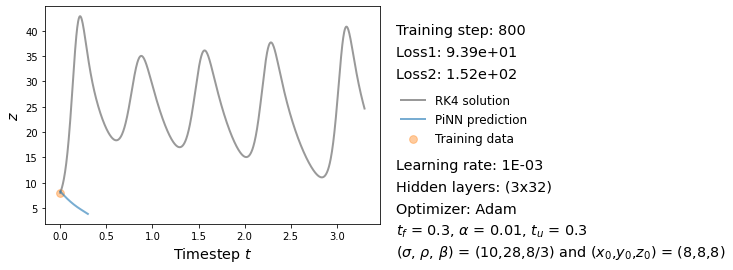

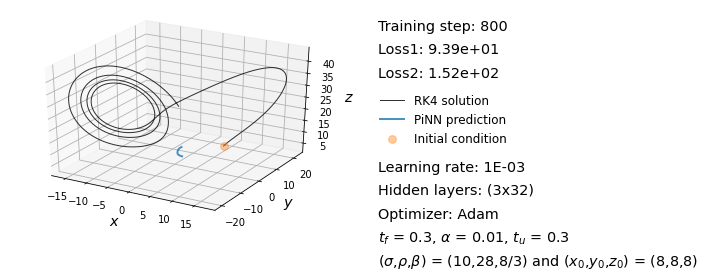

PiNN, iteration: 900, loss1: 92.9310302734375, loss2: 150.9109344482422, time: 0:00:59.894406


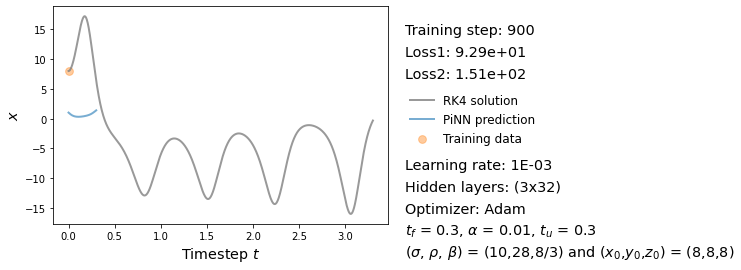

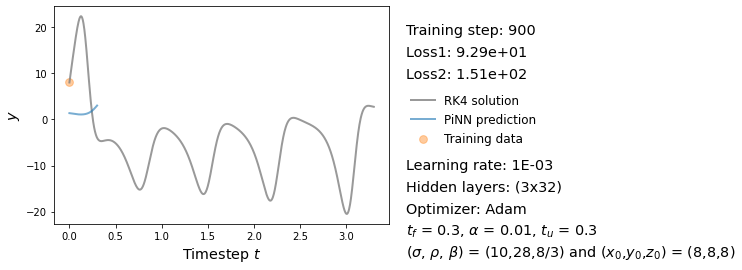

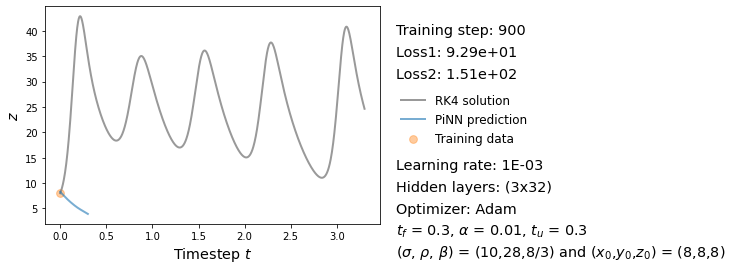

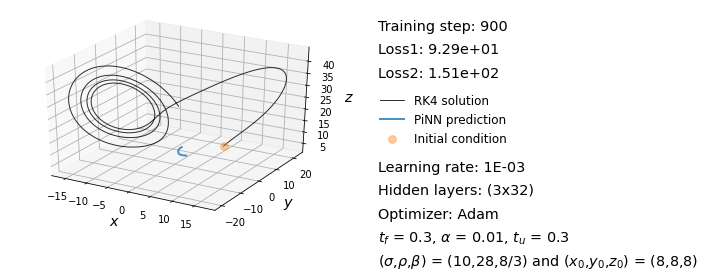

PiNN, iteration: 1000, loss1: 91.389404296875, loss2: 149.18687438964844, time: 0:01:02.292804


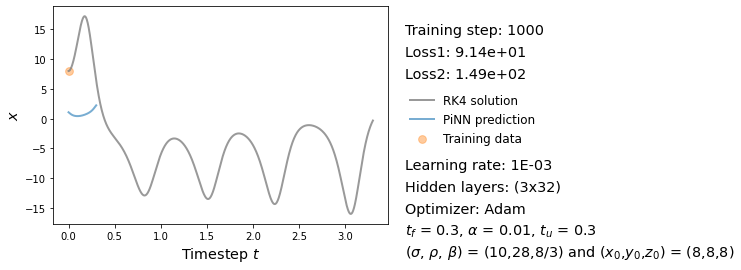

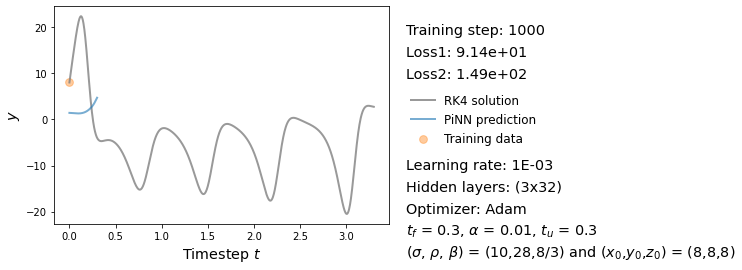

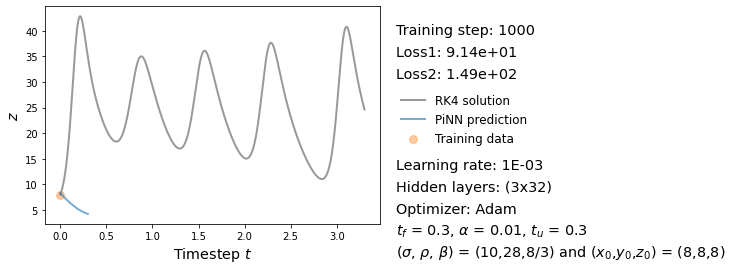

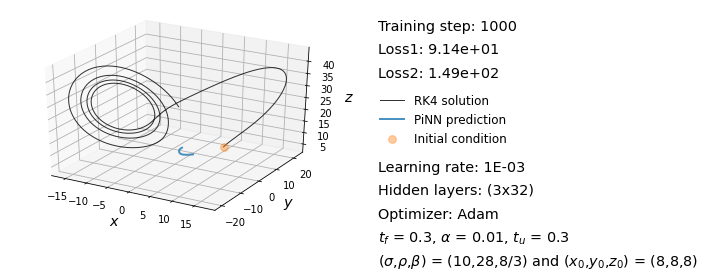

In [6]:
t_physics = torch.linspace(ti,tf,n).view(-1,1).requires_grad_(True) #Time-list used in dynamic loss2 training

# Define or load the model ----------------------------------------------------
model = FCN(INPUT,OUTPUT,N_HIDDEN,N_LAYERS) #Create a network with the specified settings
# Following is to load an already trained model -------------------------------
# model.load_state_dict(torch.load("PATHNAME.pth"))
# model.eval()

# Specify the optimizer with the specified learning rate ----------------------
optimizer = torch.optim.Adam(model.parameters(),lr=lr)   #Adam optimizer
# optimizer = torch.optim.LBFGS(model.parameters(),lr=lr)  #LBFGS optimizer (closure should be defined that returns loss)

files,files_x,files_y,files_z = [],[],[],[] #Create empty files for the intermediate results for the animation
tf_list = [] #Empty file for updating of the final time 
for i in range(iterations): #Loop over the iterations
    # i += ...              #When a model is previously trained, specify iterations here. 
    optimizer.zero_grad()   #Set gradients of all optimized tensors to zero
    
    if len(tf_list) > 0: #For updating the final time in the system
        tf = tf_list[-1]
        h = tf/n
    t_physics = torch.linspace(ti,tf,n).view(-1,1).requires_grad_(True)
    # t_np = np.random.uniform(ti,tf,n)   #Use this when you want the time to be randomly sampled
    # t_physics = torch.FloatTensor(t_np).view(-1,1).requires_grad_(True)

    #Calculation of loss1 that depends on the initial condition at t=0:
    m = model(torch.FloatTensor([0]))
    xh,yh,zh = m[0],m[1],m[2]
    loss1 = torch.mean((xh-x0)**2 + (yh-y0)**2 + (zh-z0)**2)

    #Calculation of loss2 that depends on the dynamics of the system:
    p = model(t_physics)
    px,py,pz = p[:,0],p[:,1],p[:,2]
    px,py,pz = px.view(-1,1),py.view(-1,1),pz.view(-1,1) #Correct shape
    dxdt = torch.autograd.grad(px, t_physics, torch.ones_like(px), create_graph=True)[0] #Calculate derivatives of output of PiNN w.r.t. t_physics
    dydt = torch.autograd.grad(py, t_physics, torch.ones_like(py), create_graph=True)[0]
    dzdt = torch.autograd.grad(pz, t_physics, torch.ones_like(pz), create_graph=True)[0]
    physics_x = -sigma*px + sigma*py - dxdt #Calculate f-residuals for the x,y,z differential equations
    physics_y = -px*pz + rho*px - py - dydt
    physics_z = px*py - beta*pz - dzdt
    loss2 = torch.mean(physics_x**2 + physics_y**2 + physics_z**2) #Total loss2 is the MSE of above residuals
    
    loss = 10*loss1 + loss2 #Total loss with scaling factor of 10 for loss1 due to higher importance of initial condition w.r.t. the dynamic loss
    loss.backward()         #parameter.grad += dloss/d(parameter), for every parameter (the weight/bias matrices)
    optimizer.step()        #parameter += -lr * parameter.grad
    
    if loss2 < alpha: #When dynamic loss2 is below threshold of alpha, add update_t to current tf
        tf_list.append(tf + update_t)

    if (i+1)%intermediate == 0: #Plot and save intermediate results
        t_physics = torch.linspace(ti,tf,n).view(-1,1).requires_grad_(True)
        p = model(t_physics)
        print("PiNN, iteration: {}, loss1: {}, loss2: {}, time: {}".format(i+1,loss1,loss2,datetime.now() - time))
        m1 = torch.squeeze(p.detach())
        xh,yh,zh = m1[:,0],m1[:,1],m1[:,2] #PiNN predicted results with:
        th = torch.linspace(ti,tf,n).view(-1,1) #corresponding times
        x,y,z = torch.FloatTensor(RungeKutta(dxdt_def,dydt_def,dzdt_def, x0,y0,z0, ti,float('%.2g'%(tf+3)),n)) #RK4 results with:
        t = torch.linspace(ti,tf+3,n).view(-1,1) #corresponding times that stays +3 timesteps above the PiNN predicted result

        plot2D(t,x, th,xh, x0, "x") #2D (t,x)-plot
        file = "plots_x/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files_x.append(file)
        
        plot2D(t,y, th,yh, y0, "y") #2D (t,y)-plot
        file = "plots_y/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files_y.append(file)
        
        plot2D(t,z, th,zh, z0, "z") #2D (t,z)-plot
        file = "plots_z/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files_z.append(file)
        
        plot_result(x,y,z, x0,y0,z0, xh,yh,zh) #3D plot 
        file = "plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        plt.show() #Show plots

# This is used for saving the final model
torch.save(model.state_dict(), 'model_weights_finished_{}_tf={}_parameters_{},{},{}.pth'.format(iterations,tf,sigma,rho,beta))

#Creating gif-animations:
save_gif("pinn_x.gif", files_x, fps=20, loop=0)
save_gif("pinn_y.gif", files_y, fps=20, loop=0)
save_gif("pinn_z.gif", files_z, fps=20, loop=0)
save_gif("pinn.gif", files, fps=20, loop=0)